<a href="https://colab.research.google.com/github/Pra1221/Rainfall-prediction/blob/main/RainfallPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

Load and Inspect the Data

In [20]:
# Load your dataset
df = pd.read_csv("district wise rainfall normal.csv")

In [21]:
# Show first few rows
print("\n🔹 Sample Data:")
print(df.head())


🔹 Sample Data:
                 STATE_UT_NAME       DISTRICT    JAN   FEB    MAR    APR  \
0  ANDAMAN And NICOBAR ISLANDS        NICOBAR  107.3  57.9   65.2  117.0   
1  ANDAMAN And NICOBAR ISLANDS  SOUTH ANDAMAN   43.7  26.0   18.6   90.5   
2  ANDAMAN And NICOBAR ISLANDS  N & M ANDAMAN   32.7  15.9    8.6   53.4   
3            ARUNACHAL PRADESH          LOHIT   42.2  80.8  176.4  358.5   
4            ARUNACHAL PRADESH     EAST SIANG   33.3  79.5  105.9  216.5   

     MAY    JUN    JUL    AUG    SEP    OCT    NOV    DEC  ANNUAL  Jan-Feb  \
0  358.5  295.5  285.0  271.9  354.8  326.0  315.2  250.9  2805.2    165.2   
1  374.4  457.2  421.3  423.1  455.6  301.2  275.8  128.3  3015.7     69.7   
2  343.6  503.3  465.4  460.9  454.8  276.1  198.6  100.0  2913.3     48.6   
3  306.4  447.0  660.1  427.8  313.6  167.1   34.1   29.8  3043.8    123.0   
4  323.0  738.3  990.9  711.2  568.0  206.9   29.5   31.7  4034.7    112.8   

   Mar-May  Jun-Sep  Oct-Dec  
0    540.7   1207.2    892.

In [22]:
# Column info and data types
print("\n🔹 Data Info:")
print(df.info())


🔹 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   STATE_UT_NAME  641 non-null    object 
 1   DISTRICT       641 non-null    object 
 2   JAN            641 non-null    float64
 3   FEB            641 non-null    float64
 4   MAR            641 non-null    float64
 5   APR            641 non-null    float64
 6   MAY            641 non-null    float64
 7   JUN            641 non-null    float64
 8   JUL            641 non-null    float64
 9   AUG            641 non-null    float64
 10  SEP            641 non-null    float64
 11  OCT            641 non-null    float64
 12  NOV            641 non-null    float64
 13  DEC            641 non-null    float64
 14  ANNUAL         641 non-null    float64
 15  Jan-Feb        641 non-null    float64
 16  Mar-May        641 non-null    float64
 17  Jun-Sep        641 non-null    float64
 

In [23]:
# Summary statistics
print("\n🔹 Summary Stats:")
print(df.describe())


🔹 Summary Stats:
              JAN         FEB         MAR         APR         MAY  \
count  641.000000  641.000000  641.000000  641.000000  641.000000   
mean    18.355070   20.984399   30.034789   45.543214   81.535101   
std     21.082806   27.729596   45.451082   71.556279  111.960390   
min      0.000000    0.000000    0.000000    0.000000    0.900000   
25%      6.900000    7.000000    7.000000    5.000000   12.100000   
50%     13.300000   12.300000   12.700000   15.100000   33.900000   
75%     19.200000   24.100000   33.200000   48.300000   91.900000   
max    144.500000  229.600000  367.900000  554.400000  733.700000   

               JUN          JUL          AUG         SEP         OCT  \
count   641.000000   641.000000   641.000000  641.000000  641.000000   
mean    196.007332   326.033697   291.152262  194.609048   90.446334   
std     196.556284   221.364643   152.647325   99.830540   74.990685   
min       3.800000    11.600000    14.100000    8.600000    3.100000   


In [24]:
# Null values
print("\n🔹 Missing Values:")
print(df.isnull().sum())


🔹 Missing Values:
STATE_UT_NAME    0
DISTRICT         0
JAN              0
FEB              0
MAR              0
APR              0
MAY              0
JUN              0
JUL              0
AUG              0
SEP              0
OCT              0
NOV              0
DEC              0
ANNUAL           0
Jan-Feb          0
Mar-May          0
Jun-Sep          0
Oct-Dec          0
dtype: int64


Preprocessing

In [25]:
# Step 1: Handle Missing Values
# Fill missing values with column-wise mean (can change to median or KNN if needed)
df.fillna(df.mean(numeric_only=True), inplace=True)

In [26]:
# Optional: Confirm no nulls remain
print("\n🔹 Missing Values After Imputation:")
print(df.isnull().sum())


🔹 Missing Values After Imputation:
STATE_UT_NAME    0
DISTRICT         0
JAN              0
FEB              0
MAR              0
APR              0
MAY              0
JUN              0
JUL              0
AUG              0
SEP              0
OCT              0
NOV              0
DEC              0
ANNUAL           0
Jan-Feb          0
Mar-May          0
Jun-Sep          0
Oct-Dec          0
dtype: int64


In [27]:
# Step 2: Outlier Detection (IQR method)
# Define a function to detect outliers
def detect_outliers_iqr(data, columns):
    outliers = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)].shape[0]
    return outliers

monthly_columns = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                   'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL']

In [28]:
# Check how many outliers are in each column
outliers_found = detect_outliers_iqr(df, monthly_columns)
print("\n🔹 Outliers per column (based on IQR):")
print(outliers_found)


🔹 Outliers per column (based on IQR):
{'JAN': 71, 'FEB': 59, 'MAR': 70, 'APR': 93, 'MAY': 88, 'JUN': 66, 'JUL': 48, 'AUG': 24, 'SEP': 27, 'OCT': 16, 'NOV': 67, 'DEC': 86, 'ANNUAL': 61}


In [30]:
df_cleaned = df.drop(columns=['STATE', 'DISTRICT'], errors='ignore')

print("\n✅ Preprocessing complete. Proceeding with cleaned data.")


✅ Preprocessing complete. Proceeding with cleaned data.


Feature Engineering

In [31]:
# 1. Seasonal Aggregates
df_cleaned['PreMonsoon'] = df_cleaned[['MAR', 'APR', 'MAY']].sum(axis=1)
df_cleaned['Monsoon'] = df_cleaned[['JUN', 'JUL', 'AUG', 'SEP']].sum(axis=1)
df_cleaned['PostMonsoon'] = df_cleaned[['OCT', 'NOV', 'DEC']].sum(axis=1)
df_cleaned['Winter'] = df_cleaned[['JAN', 'FEB']].sum(axis=1)

In [32]:
# 2. Rainfall Variability (Standard Deviation across months)
df_cleaned['Rainfall_STD'] = df_cleaned[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                                          'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].std(axis=1)

In [33]:
# 3. Max Rainfall Month Index (0 = Jan, ..., 11 = Dec)
df_cleaned['MaxRainMonth'] = df_cleaned[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                                          'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].idxmax(axis=1)

In [34]:
# Optionally: convert month names to numeric indices (Jan=1 to Dec=12)
month_map = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
             'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12}
df_cleaned['MaxRainMonth'] = df_cleaned['MaxRainMonth'].map(month_map)


In [35]:
print("\n✅ Feature engineering complete. New columns added:")
print(df_cleaned[['PreMonsoon', 'Monsoon', 'PostMonsoon', 'Winter', 'Rainfall_STD', 'MaxRainMonth']].head())


✅ Feature engineering complete. New columns added:
   PreMonsoon  Monsoon  PostMonsoon  Winter  Rainfall_STD  MaxRainMonth
0       540.7   1207.2        892.1   165.2    113.818630             5
1       483.5   1757.2        705.3    69.7    178.321770             6
2       405.6   1884.4        574.7    48.6    197.687826             6
3       841.3   1848.5        231.0   123.0    199.235322             7
4       645.4   3008.4        268.1   112.8    332.122661             7


Feature Selection + Train-Test Split

In [36]:
# 1. Define features and target
feature_cols = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC',
                'PreMonsoon', 'Monsoon', 'PostMonsoon', 'Winter',
                'Rainfall_STD', 'MaxRainMonth']

X = df_cleaned[feature_cols]
y = df_cleaned['ANNUAL']


In [37]:
# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n✅ Data split complete: {X_train.shape[0]} training rows, {X_test.shape[0]} test rows.")



✅ Data split complete: 512 training rows, 129 test rows.


Train Multiple Models & Compare Performance

We'll train:

Linear Regression (baseline)

Random Forest Regressor

XGBoost Regressor

Then we’ll evaluate each using:

MAE (Mean Absolute Error)

RMSE (Root Mean Square Error)

R² Score (explained variance)

In [38]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42)
}

In [39]:
# Dictionary to store evaluation results
results = {}
predictions = {}

In [40]:
# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }


In [41]:
# Show performance comparison
print("\n📊 Model Performance:")
for model_name, metrics in results.items():
    print(f"\n🔸 {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")


📊 Model Performance:

🔸 Linear Regression
MAE: 0.00
RMSE: 0.00
R2: 1.00

🔸 Random Forest
MAE: 63.22
RMSE: 150.89
R2: 0.97

🔸 XGBoost
MAE: 61.24
RMSE: 114.33
R2: 0.99


Plot Actual vs Predicted Rainfall

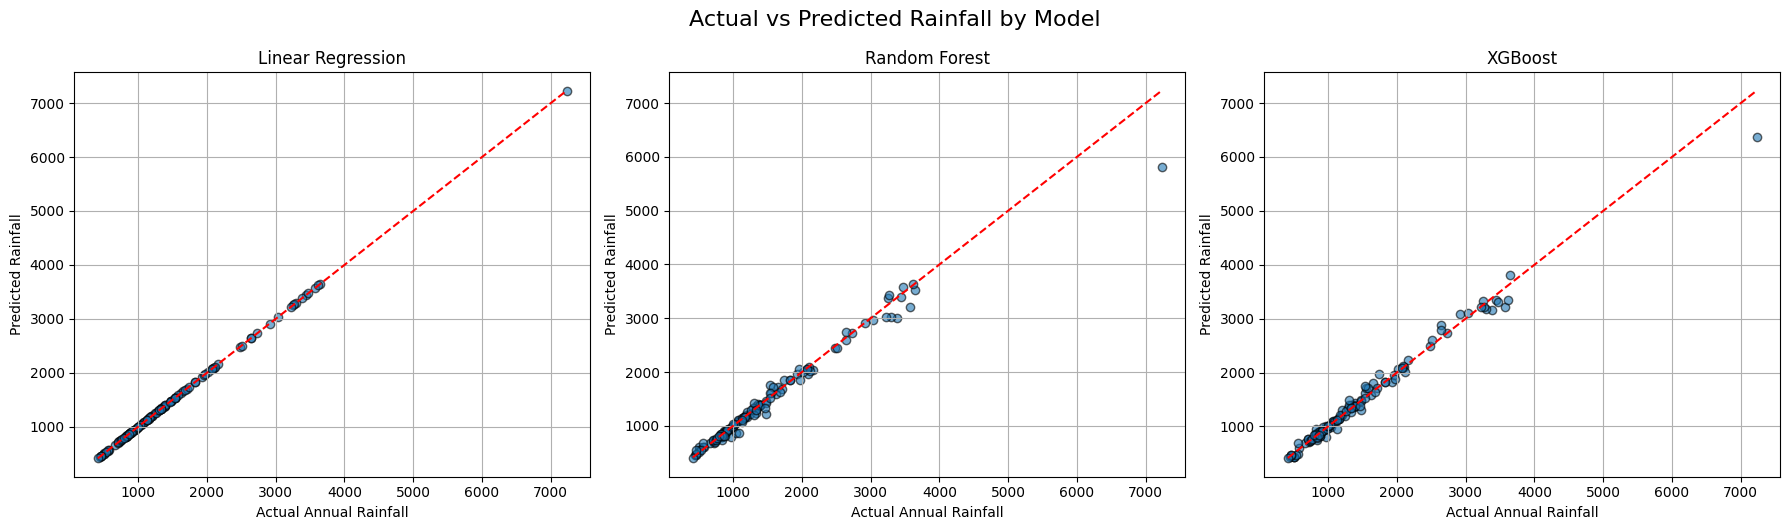

In [42]:
plt.figure(figsize=(18, 5))

for idx, (name, y_pred) in enumerate(predictions.items(), 1):
    plt.subplot(1, 3, idx)
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # perfect prediction line
    plt.xlabel("Actual Annual Rainfall")
    plt.ylabel("Predicted Rainfall")
    plt.title(name)
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Actual vs Predicted Rainfall by Model", fontsize=16, y=1.05)
plt.show()

Save the Best Model for Future Use

In [44]:
# Step 1: best model
best_model = models['Linear Regression']

In [46]:
# Step 2: Save the model
joblib.dump(best_model, "rainfall_predictor_model.pkl")

print("\n✅ Model saved successfully as rainfall_predictor_model.pkl")


✅ Model saved successfully as rainfall_predictor_model.pkl


 Predict Annual Rainfall from User Input

1. Loads your saved model

2. Accepts monthly rainfall as input

3. Applies the same feature engineering

4. Predicts the annual rainfall

In [47]:
# Load the saved model
model = joblib.load("rainfall_predictor_model.pkl")

In [48]:
# Get user input (you can replace this with actual input or form values)
user_input = {
    'JAN': 12, 'FEB': 8, 'MAR': 15, 'APR': 35, 'MAY': 40, 'JUN': 200,
    'JUL': 250, 'AUG': 210, 'SEP': 160, 'OCT': 90, 'NOV': 40, 'DEC': 20
}

In [49]:
# Convert to DataFrame
df_input = pd.DataFrame([user_input])

In [50]:
# Feature Engineering (must match training time)
df_input['PreMonsoon'] = df_input[['MAR', 'APR', 'MAY']].sum(axis=1)
df_input['Monsoon'] = df_input[['JUN', 'JUL', 'AUG', 'SEP']].sum(axis=1)
df_input['PostMonsoon'] = df_input[['OCT', 'NOV', 'DEC']].sum(axis=1)
df_input['Winter'] = df_input[['JAN', 'FEB']].sum(axis=1)
df_input['Rainfall_STD'] = df_input[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                                     'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].std(axis=1)
df_input['MaxRainMonth'] = df_input[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                                     'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].idxmax(axis=1)


In [51]:
# Convert month name to number (Jan=1 to Dec=12)
month_map = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
             'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12}
df_input['MaxRainMonth'] = df_input['MaxRainMonth'].map(month_map)


In [52]:
# Final columns used for prediction
features_used = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC',
                 'PreMonsoon', 'Monsoon', 'PostMonsoon', 'Winter',
                 'Rainfall_STD', 'MaxRainMonth']


In [53]:
# Predict
predicted_annual = model.predict(df_input[features_used])[0]
print(f"\n🌧️ Predicted Annual Rainfall: {predicted_annual:.2f} mm")


🌧️ Predicted Annual Rainfall: 1080.00 mm
